<img src="Assets/banner.jpg" alt="Solar Power Generation" style="width: 100%; height: auto;"/>

## Introduction
As we all know, solar energy forecasting is crucial for optimizing energy production and distribution in renewable energy systems. Accurate predictions enable better integration into energy grids, improve operational efficiency, and help to balance demand and supply. In this paper, I'll use machine learning techniques to predict solar power generation based on historical weather data and solar panel output.

## Dataset
This project is based on [Solar Power Generation Dataset](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data) from `Kaggle`.

I used `Kaggle` API to get the dataset. However, you can download it manually.

Install the `Kaggle` package if you haven’t already:

Download the dataset by running:

## Preprocessing the Data
With the dataset downloaded, the next step is to preprocess it. Data preprocessing ensures that the data is clean and ready for modeling. Here are the main steps involved:

### Load the Data: 
Simply use `pandas` to load the dataset and inspect it.
Load both generation and weather sensor data for Plant 1 and Plant 2.

In [1]:
import pandas as pd


plant1_gen = pd.read_csv("data/Plant_1_Generation_Data.csv")
plant2_gen = pd.read_csv("data/Plant_2_Generation_Data.csv")
plant1_weather = pd.read_csv("data/Plant_1_Weather_Sensor_Data.csv")
plant2_weather = pd.read_csv("data/Plant_2_Weather_Sensor_Data.csv")

print("Plant 1 Generation Data Columns:\n", plant1_gen.columns.tolist())
print("Plant 1 Weather Data Columns:\n", plant1_weather.columns.tolist(), '\n')

print("Plant 1 Generation Data Shape:\n", plant1_gen.shape)
print("Plant 1 Weather Data Shape:\n", plant1_weather.shape, '\n')

print("Plant 2 Generation Data Columns:\n", plant2_gen.columns.tolist())
print("Plant 2 Weather Data Columns:\n", plant2_weather.columns.tolist(), '\n')

print("Plant 2 Generation Data Shape:\n", plant2_gen.shape)
print("Plant 2 Weather Data Shape:\n", plant2_weather.shape, '\n')



Plant 1 Generation Data Columns:
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
Plant 1 Weather Data Columns:
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'] 

Plant 1 Generation Data Shape:
 (68778, 7)
Plant 1 Weather Data Shape:
 (3182, 6) 

Plant 2 Generation Data Columns:
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
Plant 2 Weather Data Columns:
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'] 

Plant 2 Generation Data Shape:
 (67698, 7)
Plant 2 Weather Data Shape:
 (3259, 6) 



---

`DATE_TIME`: This is the timestamp for each data entry, capturing the specific date and time of the record. Can be used to extract additional temporal features like HOUR, DAY_OF_WEEK, or MONTH to capture patterns related to time (e.g., daily or seasonal variations in solar generation).

`PLANT_ID`: Unique identifier for the solar power plant where the data was recorded.

`SOURCE_KEY`: Identifier for a specific data source or sensor within the plant (e.g., individual solar panels or inverters). Like PLANT_ID, this is generally not used as a feature for prediction since it doesn’t add meaningful information for predicting power output.

`DC_POWER`: Direct Current (DC) power output generated by the solar panels. DC power is typically the raw power produced before being converted.

`AC_POWER`: Alternating Current (AC) power output after conversion from DC. AC power is what’s usable by electrical systems or sent to the grid. This is a key target variable (y) for predicting solar power generation, as it represents the actual usable power output.

`DAILY_YIELD`: Total energy generated by the solar plant in one day, measured up to the specific timestamp.

`TOTAL_YIELD`: Cumulative energy generated by the plant since it started operating, measured up to the timestamp.

`AMBIENT_TEMPERATURE`: The air temperature around the solar plant. High ambient temperatures can decrease the efficiency of solar panels.

`MODULE_TEMPERATURE`: The temperature of the solar modules themselves. This is typically higher than ambient temperature due to direct exposure to sunlight.

`IRRADIATION`: The amount of solar radiation reaching the solar panels, usually measured in units like kW/m².

---

Key Predictive Features (X): `DC_POWER`, `AMBIENT_TEMPERATURE`, `MODULE_TEMPERATURE`, `IRRADIATION`, along with extracted time features from `DATE_TIME` if relevant.

Target Variable (y): `AC_POWER`.

Features to Exclude: `PLANT_ID`, `SOURCE_KEY`, `DAILY_YIELD`, and `TOTAL_YIELD`, as they don’t contribute meaningful predictive information for the model.

---

### Convert Date Time Columns: 
Convert `DATE_TIME` columns to datetime format for both plant datasets.

In [2]:
# Convert DATE_TIME columns to datetime format
for df in [plant1_gen, plant1_weather, plant2_gen, plant2_weather]:
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

/tmp/ipykernel_225838/1244794693.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])


### Data Visualization:
We can check several charts, as they help in understanding the dataset.

#### Temperature over Time Comparison for Plant 1 and Plant 2:

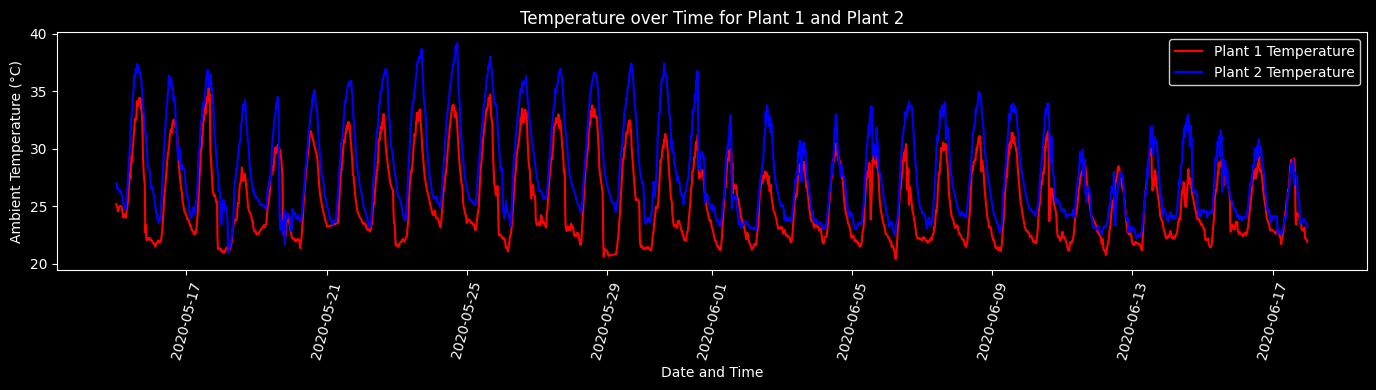

In [3]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.figure(figsize=(14, 4))

plt.plot(plant1_weather['DATE_TIME'], plant1_weather['AMBIENT_TEMPERATURE'], label='Plant 1 Temperature', color='red')
plt.plot(plant2_weather['DATE_TIME'], plant2_weather['AMBIENT_TEMPERATURE'], label='Plant 2 Temperature', color='blue')

plt.xlabel('Date and Time')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Temperature over Time for Plant 1 and Plant 2')

plt.legend(facecolor='black', edgecolor='white')

plt.xticks(rotation=75)
plt.yticks()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### AC Power Generation over Time for Plant 1 and Plant 2:

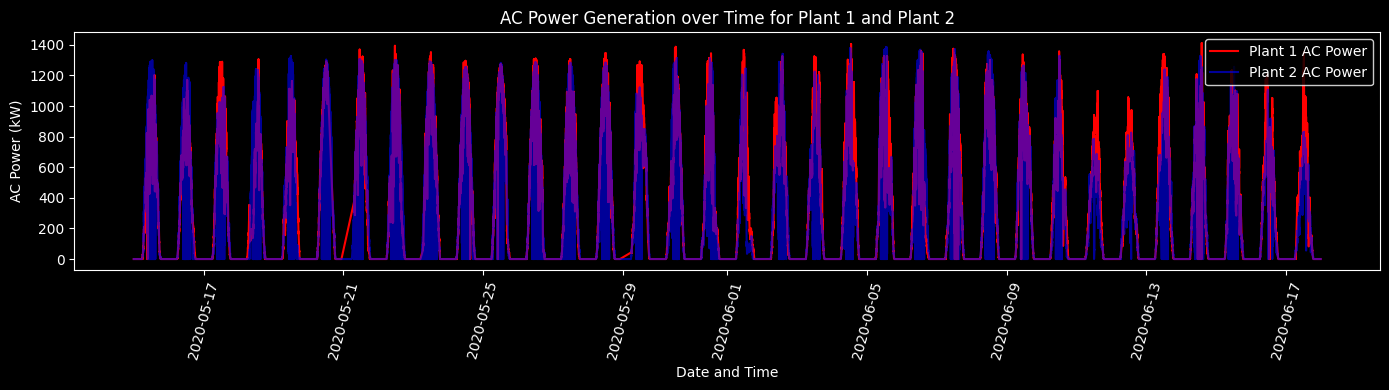

In [4]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.figure(figsize=(14, 4))

plt.plot(plant1_gen['DATE_TIME'], plant1_gen['AC_POWER'], label='Plant 1 AC Power', color='red', alpha=1)
plt.plot(plant2_gen['DATE_TIME'], plant2_gen['AC_POWER'], label='Plant 2 AC Power', color='blue', alpha=0.6)

plt.xlabel('Date and Time')
plt.ylabel('AC Power (kW)')
plt.title('AC Power Generation over Time for Plant 1 and Plant 2')

plt.legend(facecolor='black', edgecolor='white')

plt.xticks(rotation=75)
plt.yticks()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### Merge Generation and Weather Data: 
Merge generation and weather data for each plant based on `DATE_TIME`.

In [5]:
# Merge Plant 1 data
plant_1_data = pd.merge(plant1_gen, plant1_weather, on='DATE_TIME')
print(plant_1_data.shape)

# Merge Plant 2 data
plant_2_data = pd.merge(plant2_gen, plant2_weather, on='DATE_TIME')
print(plant_2_data.shape)

(68774, 12)
(67698, 12)


### Combine Both Plants’ Data:
After merging, concatenate the datasets from both plants into one.

In [6]:
# Concatenate data from both plants
combined_data = pd.concat([plant_1_data, plant_2_data], ignore_index=True)
print(combined_data.shape) 

(136472, 12)


### Handle Missing Values: 
Check for missing values in the combined dataset and handle them. Since there is no missing value, we can skip handeling missing values step.

In [7]:
# Check for missing values
print(combined_data.isnull().sum())

DATE_TIME              0
PLANT_ID_x             0
SOURCE_KEY_x           0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
PLANT_ID_y             0
SOURCE_KEY_y           0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


### Feature Engineering: 
Extract useful time-based features such as `hour`, `day of the week`, and `month` from the `DATE_TIME` column.

In [8]:
# Extract time-based features
combined_data['HOUR'] = combined_data['DATE_TIME'].dt.hour
combined_data['DAY_OF_WEEK'] = combined_data['DATE_TIME'].dt.dayofweek
combined_data['MONTH'] = combined_data['DATE_TIME'].dt.month

print(len(combined_data.columns))
print(combined_data.columns.tolist())

15
['DATE_TIME', 'PLANT_ID_x', 'SOURCE_KEY_x', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_y', 'SOURCE_KEY_y', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'DAY_OF_WEEK', 'MONTH']


### Drop Unnecessary Columns: 
Remove columns that aren’t necessary for prediction.

In [9]:
# Drop unnecessary columns
combined_data.drop(['PLANT_ID_x', 'SOURCE_KEY_x', 'PLANT_ID_y', 'SOURCE_KEY_y', 'DATE_TIME', 'DAILY_YIELD', 'TOTAL_YIELD'], axis=1, inplace=True)
print(len(combined_data.columns))
print(combined_data.columns.tolist())

8
['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'DAY_OF_WEEK', 'MONTH']


### Normalize/Standardize Features: 
Scale features like temperature, irradiation, and power output.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Columns to scale
cols_to_scale = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']
combined_data[cols_to_scale] = scaler.fit_transform(combined_data[cols_to_scale])

for column in ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']:
    print(combined_data[column].head(), '\n')

0   -0.405085
1   -0.405085
2   -0.405085
3   -0.405085
4   -0.405085
Name: AMBIENT_TEMPERATURE, dtype: float64 

0   -0.767835
1   -0.767835
2   -0.767835
3   -0.767835
4   -0.767835
Name: MODULE_TEMPERATURE, dtype: float64 

0   -0.755001
1   -0.755001
2   -0.755001
3   -0.755001
4   -0.755001
Name: IRRADIATION, dtype: float64 

0   -0.722792
1   -0.722792
2   -0.722792
3   -0.722792
4   -0.722792
Name: AC_POWER, dtype: float64 



### Prepare Target and Feature Sets: 
Separate the target variable (`AC_POWER`) and the feature set.

#### Define feature matrix X:

In [11]:
# Define feature matrix X and target variable y
X = combined_data.drop(['AC_POWER'], axis=1)
print(X.head(), '\n')

   DC_POWER  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  HOUR  \
0       0.0            -0.405085           -0.767835    -0.755001     0   
1       0.0            -0.405085           -0.767835    -0.755001     0   
2       0.0            -0.405085           -0.767835    -0.755001     0   
3       0.0            -0.405085           -0.767835    -0.755001     0   
4       0.0            -0.405085           -0.767835    -0.755001     0   

   DAY_OF_WEEK  MONTH  
0            4      5  
1            4      5  
2            4      5  
3            4      5  
4            4      5   



#### Define target variable y:

In [12]:
y = combined_data['AC_POWER']
print(y.describe(), '\n')

count    1.364720e+05
mean     1.999300e-17
std      1.000004e+00
min     -7.227921e-01
25%     -7.227921e-01
50%     -7.136041e-01
75%      6.780449e-01
max      2.988488e+00
Name: AC_POWER, dtype: float64 



### Split the Data into Training and Testing Sets: 
Use a portion of the combined data for training and the remaining for testing (validation). This will allow us to validate the model’s performance on a separate subset.

In [13]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(109177, 7)
(27295, 7)
(109177,)
(27295,)


### Model Definition:
Here, I define models for regression tasks.

•	**Linear Regression**: A simple linear model that predicts the target variable based on a weighted sum of input features.

•	**Decision Tree Regressor**: A model that uses a tree structure to split data based on feature values, making predictions by following branches to leaf nodes.

•	**Gradient Boosting Regressor**: An ensemble technique that builds multiple sequential models, with each new model correcting errors from the previous one.

•	**Random Forest Regressor**: An ensemble of decision trees that aggregates predictions from many trees to improve accuracy and reduce overfitting.

•	**MLP Regressor**: A feed-forward neural network with multiple layers, suitable for capturing complex relationships in the data.

•	**Deep Neural Network (DNN)**: A multi-layer neural network with dense layers and ReLU activations, designed to learn hierarchical representations in data for regression tasks.

In [14]:
# Import necessary libraries for models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(random_state=42),
    "Deep Neural Network (DNN)": Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
}

2025-06-29 02:21:30.026328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751152890.048102  225838 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751152890.054617  225838 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751152890.072343  225838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751152890.072370  225838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751152890.072373  225838 computation_placer.cc:177] computation placer alr

### Model Training:

In [15]:
# Function to train each model
def train_model(name, model, X_train, y_train):
    print(f"Training {name}...")
    
    # If the model is a Keras model, we need to compile and fit it differently
    if isinstance(model, tf.keras.Model):
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    return model

### Evaluation:
This section evaluates the performance of each model after training..

In [16]:
# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate and store model metrics
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # If the model is a Keras model, flatten the predictions
    if isinstance(model, tf.keras.Model):
        y_pred = y_pred.flatten()
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    return {
        "metrics": {
            "MAE": mae,
            "MSE": mse,
            "R2 Score": r2
        },
        "data": {
            "y_test": y_test,
            "y_pred": y_pred
        }
    }

Now we combine both the training and evaluation steps, iterating over all models.

In [17]:
# Dictionary to store evaluation metrics for each model
results = {}

# Loop through and train each model, then evaluate
for name, model in models.items():
    # Train the model
    trained_model = train_model(name, model, X_train, y_train)
    
    # Evaluate the model
    model_results = evaluate_model(name, trained_model, X_test, y_test)
    
    # Store the results
    results[name] = model_results
    
    # Print results
    print(f"{name}:\n\t- MAE: {model_results['metrics']['MAE']}, MSE: {model_results['metrics']['MSE']}, R2 Score: {model_results['metrics']['R2 Score']}\n")

Training Linear Regression...
Linear Regression:
	- MAE: 0.1947954817176827, MSE: 0.16681500423291834, R2 Score: 0.833702434536792

Training Decision Tree Regressor...
Decision Tree Regressor:
	- MAE: 0.0007104922751816183, MSE: 8.308251983631523e-05, R2 Score: 0.9999171751914951

Training Gradient Boosting Regressor...
Gradient Boosting Regressor:
	- MAE: 0.02847419729653401, MSE: 0.004197302010712944, R2 Score: 0.9958157174823388

Training Random Forest Regressor...
Random Forest Regressor:
	- MAE: 0.0005388114314002997, MSE: 3.254935609689035e-05, R2 Score: 0.9999675516078352

Training MLP Regressor...
MLP Regressor:
	- MAE: 0.05474654586411614, MSE: 0.012095396566566911, R2 Score: 0.9879421218038419

Training Deep Neural Network (DNN)...
853/853 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step
Deep Neural Network (DNN):
	- MAE: 0.0025657718020636504, MSE: 0.00018635089017461523, R2 Score: 0.9998142271464102



### Display Results:
Finally, we can display the evaluation results in a clean, tabular format using pandas:

In [19]:
# Extract only the "metrics" part from the results dictionary and convert it to a DataFrame
evaluation_metrics_df = pd.DataFrame({model: result["metrics"] for model, result in results.items()}).T  # Transpose for better readability

# Display the model evaluation metrics
print("Model Evaluation Metrics:")
display(evaluation_metrics_df)

Model Evaluation Metrics:


,MAE,MSE,R2 Score
Linear Regression,0.194795,0.166815,0.833702
Decision Tree Regressor,0.000710,0.000083,0.999917
Gradient Boosting Regressor,0.028474,0.004197,0.995816
Random Forest Regressor,0.000539,0.000033,0.999968
MLP Regressor,0.054747,0.012095,0.987942
Deep Neural Network (DNN),0.002566,0.000186,0.999814


/tmp/ipykernel_225838/2558749920.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_225838/2558749920.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_225838/2558749920.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


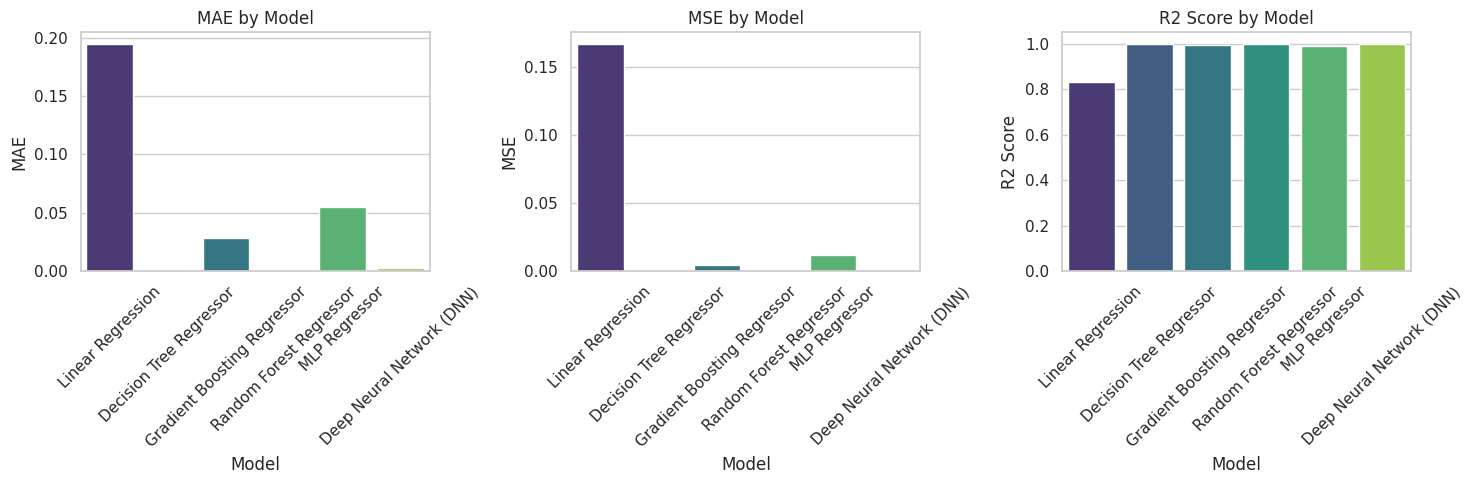

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

metrics = ['MAE', 'MSE', 'R2 Score']

# Plot each metric
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(
        x='index', y=metric,
        data=evaluation_metrics_df.reset_index(),
        palette="viridis"
    )
    plt.title(f'{metric} by Model')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Plotting Confusion Matrices:

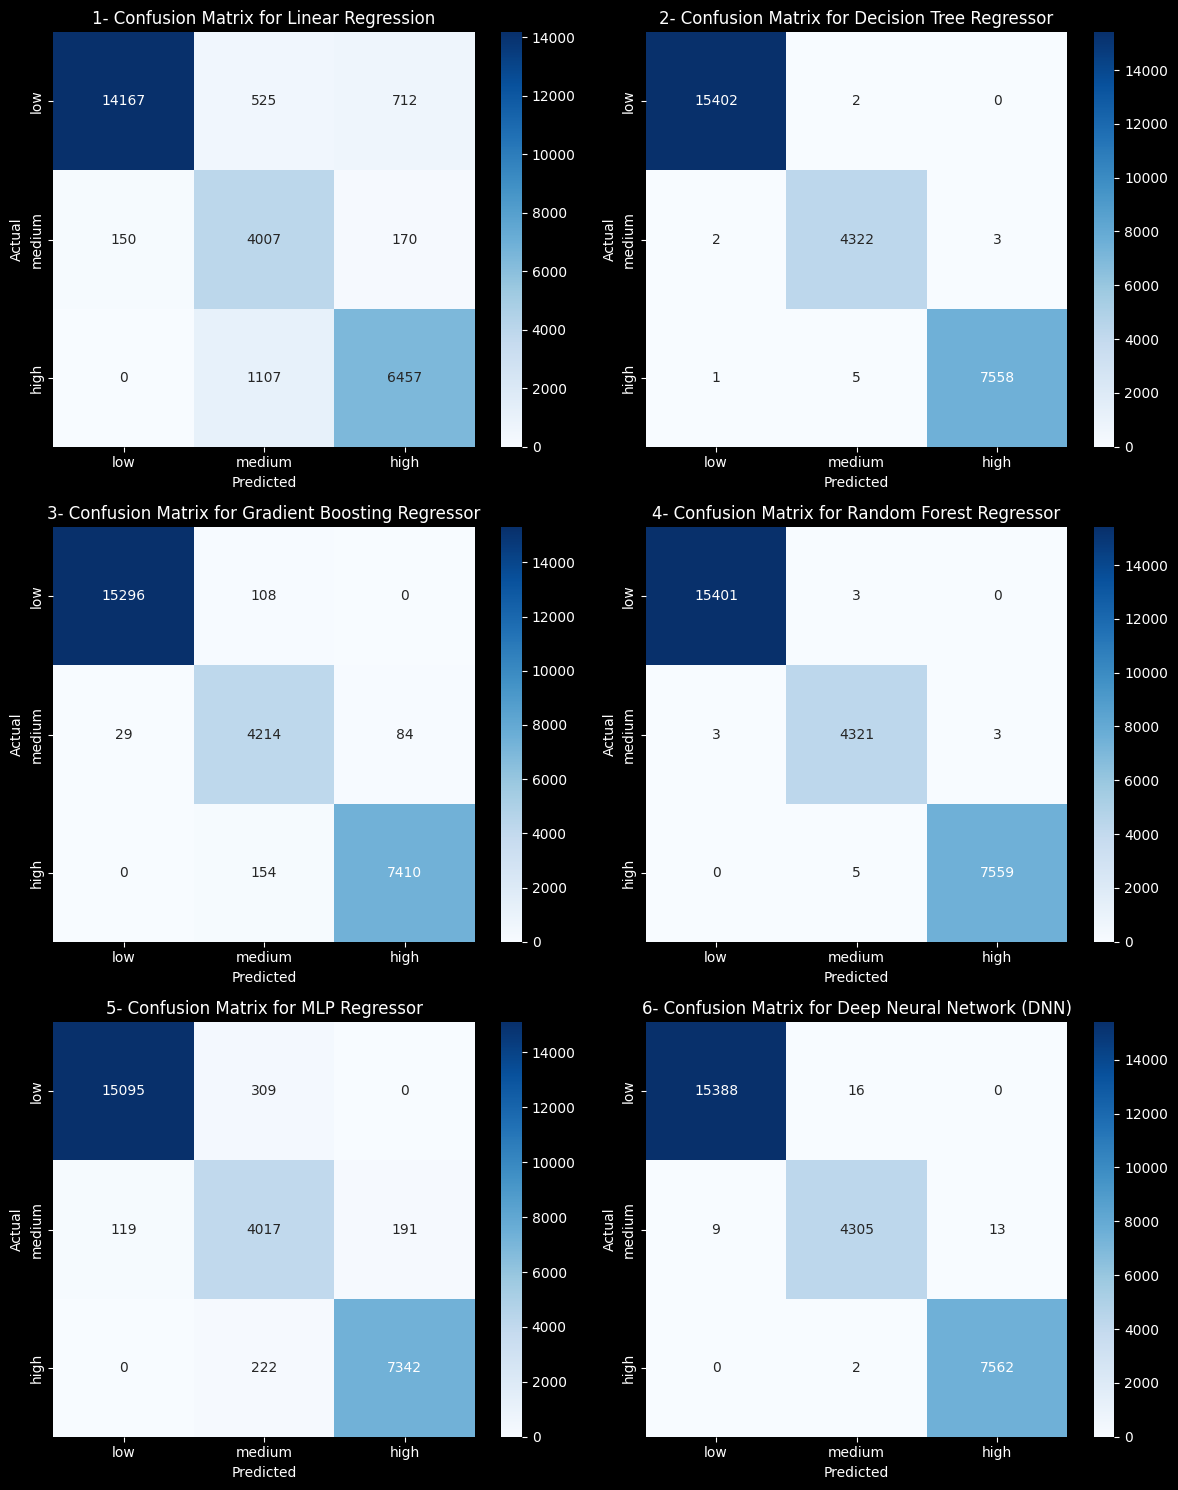

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

n_rows = (len(results) + 1) // 2  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows)) # Create a figure with subplots arranged in a 2x2 grid (or more rows if needed)

# Flatten axes array for easier indexing if it's 2D
axes = axes.flatten()

# Loop through models and compute confusion matrix
for idx, (model, evaluation) in enumerate(results.items()):
    thresholds = [-0.5, 0.5]
    
    # Convert predictions and actual values to categories
    y_test_categories = np.digitize(evaluation['data']['y_test'], [-np.inf, *thresholds, np.inf]) - 1
    y_pred_categories = np.digitize(evaluation['data']['y_pred'], [-np.inf, *thresholds, np.inf]) - 1
    
    # Plot a confusion matrix using seaborn heatmap
    labels = ['low', 'medium', 'high']
    sns.heatmap(confusion_matrix(y_test_categories, y_pred_categories, labels=[0, 1, 2]),
                annot=True, fmt='g', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=axes[idx])
    
    axes[idx].set_title(f'{idx+1}- Confusion Matrix for {model}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


### 🔍 Model Performance Commentary

1. **Linear Regression**

   * **Performance**: Highest error (MAE: 0.1948, MSE: 0.1668) and lowest R² (0.8337), indicating poor fit to the data.
   * **Pros**: Simple, interpretable, fast.
   * **Cons**: Assumes linearity; struggles with non-linear patterns.
   * **Conclusion**: Baseline model; significantly underperforms compared to all other methods.

2. **Decision Tree Regressor**

   * **Performance**: Very low errors (MAE: 0.0007, MSE: 0.000083) and near-perfect R² (0.9999).
   * **Pros**: Captures non-linearity well, interpretable, quick to train.
   * **Cons**: Susceptible to overfitting; lacks robustness without pruning or ensembling.
   * **Conclusion**: Performs extremely well, but slightly less stable than ensemble-based models.

3. **Gradient Boosting Regressor**

   * **Performance**: Low error (MAE: 0.0285, MSE: 0.0042) with strong R² (0.9958).
   * **Pros**: Excellent at modeling complex relationships; resistant to overfitting.
   * **Cons**: Training is slower and requires hyperparameter tuning.
   * **Conclusion**: High-performing and well-balanced, though slightly outperformed by Random Forest and DNN.

4. **Random Forest Regressor**

   * **Performance**: Best overall (MAE: 0.0005, MSE: 0.000032, R²: 0.99997).
   * **Pros**: High accuracy, stable, resistant to overfitting, handles non-linearity robustly.
   * **Cons**: Less interpretable; higher memory and inference cost.
   * **Conclusion**: Top performer in both accuracy and reliability.

5. **MLP Regressor**

   * **Performance**: Moderate errors (MAE: 0.0547, MSE: 0.0121), strong R² (0.9879).
   * **Pros**: Flexible in learning non-linearities.
   * **Cons**: Sensitive to hyperparameters; less consistent than ensembles.
   * **Conclusion**: Solid performer, but inferior to Random Forest, DNN, and Gradient Boosting in this case.

6. **Deep Neural Network (DNN)**

   * **Performance**: Near-top performance (MAE: 0.0026, MSE: 0.000186, R²: 0.9998).
   * **Pros**: Excellent for complex, high-dimensional data.
   * **Cons**: High training cost; requires larger data and careful tuning.
   * **Conclusion**: Nearly matches Random Forest in accuracy but with greater complexity and resource demands.

---

### 📊 Overall Summary

* **Best Performer**: **Random Forest Regressor** — highest accuracy and generalization with minimal error.
* **Close Contender**: **DNN** — powerful but more resource-intensive.
* **Most Balanced**: **Gradient Boosting** — strong accuracy with manageable complexity.
* **Fast Baseline**: **Linear Regression** — fast but too simplistic for this dataset.
* **Neural Networks**: **MLP** offers flexibility but is outclassed by DNN and ensemble methods here.
